# Porter: Neural Networks Regression

## Introduction
Porter, India's largest marketplace for intra-city logistics, aims to estimate delivery times for orders placed through its platform. By leveraging a dataset that includes various features related to orders, restaurants, and delivery partners, we will develop a regression model using neural networks to predict delivery times accurately. This project involves data preprocessing, feature engineering, and building a neural network model for regression.


# Data Analysis

In this section, we will perform a thorough analysis of the dataset. This includes:

- **Understanding Each Feature**: We will analyze each column for unique values, null values, and data types.
- **Exploratory Data Analysis (EDA)**: Visualizing and summarizing the dataset to identify patterns, trends, and potential outliers.
- **Feature Engineering**: Creating new features such as delivery time in hours and extracting useful information from timestamps.
- **Handling Missing Data**: Checking for null values and deciding on the appropriate strategies to handle them.
- **Data Cleaning**: Ensuring the dataset is clean and ready for model building by removing or imputing missing values, correcting data types, and addressing inconsistencies.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [ ]:
data = pd.read_csv("dataset.csv")
data.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  
0                    33.0                 14.0                      21.0  
1                     1.0                  2.0                       2.0  
2                     1.0                  0.0                       0.0  
3                     1.0                  1.0                       2.0  
4                     6.0                  6.0                       9.0

In [ ]:
data.shape

(197428, 14)

In [ ]:
data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders'],
      dtype='object')

In [ ]:
data.describe()

market_id  order_protocol    total_items       subtotal  \
count  196441.000000   196433.000000  197428.000000  197428.000000   
mean        2.978706        2.882352       3.196391    2682.331402   
std         1.524867        1.503771       2.666546    1823.093688   
min         1.000000        1.000000       1.000000       0.000000   
25%         2.000000        1.000000       2.000000    1400.000000   
50%         3.000000        3.000000       3.000000    2200.000000   
75%         4.000000        4.000000       4.000000    3395.000000   
max         6.000000        7.000000     411.000000   27100.000000   

       num_distinct_items  min_item_price  max_item_price  \
count       197428.000000   197428.000000   197428.000000   
mean             2.670791      686.218470     1159.588630   
std              1.630255      522.038648      558.411377   
min              1.000000      -86.000000        0.000000   
25%              1.000000      299.000000      800.000000   
50%              2.000000      595.000000     1095.000000   
75%              3.000000      949.000000     1395.000000   
max             20.000000    14700.000000    14700.000000   

       total_onshift_partners  total_busy_partners  total_outstanding_orders  
count           181166.000000        181166.000000             181166.000000  
mean                44.808093            41.739747                 58.050065  
std                 34.526783            32.145733                 52.661830  
min                 -4.000000            -5.000000                 -6.000000  
25%                 17.000000            15.000000                 17.000000  
50%                 37.000000            34.000000                 41.000000  
75%                 65.000000            62.000000                 85.000000  
max                171.000000           154.000000                285.000000

In [ ]:
data.dtypes

market_id                   float64
created_at                   object
actual_delivery_time         object
store_id                     object
store_primary_category       object
order_protocol              float64
total_items                   int64
subtotal                      int64
num_distinct_items            int64
min_item_price                int64
max_item_price                int64
total_onshift_partners      float64
total_busy_partners         float64
total_outstanding_orders    float64
dtype: object

In [ ]:
data.isnull().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
dtype: int64

## Understanding Each Column Feature

In this section, we will explore each column in the dataset to understand its characteristics, including:

1. **Unique Values**: Count the unique values in each column to understand the variability.
2. **Null Values**: Check for any missing values in the columns.
3. **Data Types**: Identify the data types of each column to ensure appropriate data handling.

We will analyze the following features:

- **market_id**: Unique identifier for the market where the restaurant is located.
- **created_at**: The timestamp when the order was placed. This will be converted to datetime format.
- **actual_delivery_time**: The timestamp when the order was delivered. This will also be converted to datetime format.
- **store_primary_category**: Category of the restaurant, indicating the type of cuisine or service.
- **order_protocol**: Integer code representing how the order was placed (e.g., through Porter, call to restaurant, pre-booked, etc.).
- **total_items**: Total number of items in the order.
- **subtotal**: The final price of the order.
- **num_distinct_items**: The number of distinct items in the order.
- **min_item_price**: The price of the cheapest item in the order.
- **max_item_price**: The price of the most expensive item in the order.
- **total_onshift_partners**: Number of delivery partners on duty when the order was placed.
- **total_busy_partners**: Number of delivery partners occupied with other tasks at the time.
- **total_outstanding_orders**: Total number of orders that need to be fulfilled at the moment.

Let's proceed by examining each column for uniqueness, null values, and data types.


In [ ]:
data.market_id.unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [ ]:
data.market_id.value_counts()

market_id
2.0    55058
4.0    47599
1.0    38037
3.0    23297
5.0    18000
6.0    14450
Name: count, dtype: int64

In [ ]:
data['created_at'].unique().shape,data['actual_delivery_time'].unique()

((180985,),
 array(['2015-02-06 23:27:16', '2015-02-10 22:56:29',
        '2015-01-22 21:09:09', ..., '2015-01-24 05:36:16',
        '2015-02-01 19:23:22', '2015-02-08 20:01:41'], dtype=object))

In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

### Analysis of Busy Delivery Partners by Hour

The code performs an analysis to determine the average number of busy delivery partners across different hours of the day.

**Results**:
- The top 3 hours with the highest average number of busy delivery partners are 2, 3, and 1. This indicates that these early morning hours have the highest number of delivery partners occupied with other tasks, which may impact delivery times.

The visualization provides insights into peak periods, aiding in better resource planning and allocation.


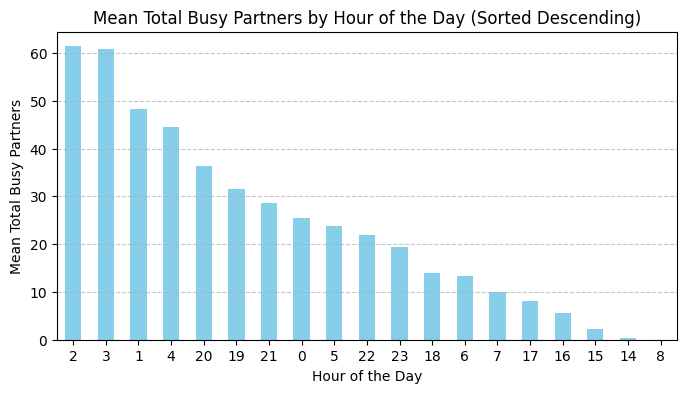

In [ ]:
data['hour'] = data['created_at'].dt.hour

hourly_busy_partners = data.groupby('hour')['total_busy_partners'].mean()

hourly_busy_partners_sorted = hourly_busy_partners.sort_values(ascending=False)

plt.figure(figsize=(8,4))
hourly_busy_partners_sorted.plot(kind='bar', color='skyblue')
plt.title('Mean Total Busy Partners by Hour of the Day (Sorted Descending)')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Total Busy Partners')
plt.xticks(rotation=0)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()

### Analysis of Onshift Delivery Partners by Hour

The following analysis calculates and visualizes the average number of onshift delivery partners for each hour of the day.

**Results**:
- The top 3 hours with the highest average number of onshift delivery partners are 2, 3, and 1. This indicates that these early morning hours have the highest average number of delivery partners available for orders.

The visualization provides insights into the availability of onshift delivery partners throughout the day.




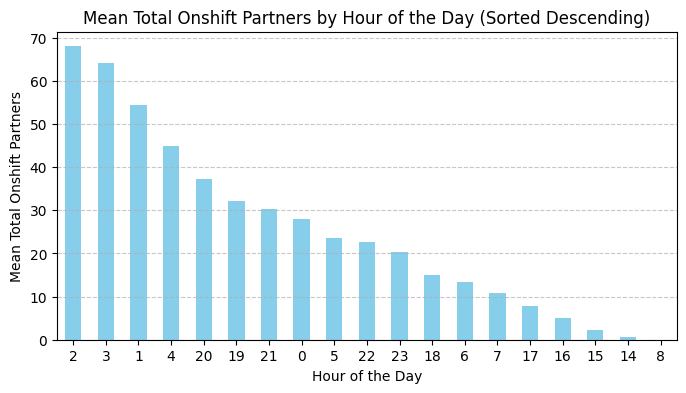

In [ ]:
# Grouping by hour and calculating the mean of 'total_onshift_partners'
hourly_onshift_partners = data.groupby('hour')['total_onshift_partners'].mean()

# Sorting the hours by mean in descending order
hourly_onshift_partners_sorted = hourly_onshift_partners.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,4))
hourly_onshift_partners_sorted.plot(kind='bar',color='skyblue')
plt.title('Mean Total Onshift Partners by Hour of the Day (Sorted Descending)')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Total Onshift Partners')
plt.xticks(rotation=0)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()

### Analysis of Outstanding Orders by Hour

The following analysis calculates and visualizes the average number of outstanding orders for each hour of the day.


**Results**:
- The plot illustrates the hours with the highest average number of outstanding orders. This helps in understanding which hours experience the most order backlog.

The `hour` column is dropped from the dataset after the analysis, as it is no longer needed for further processing.


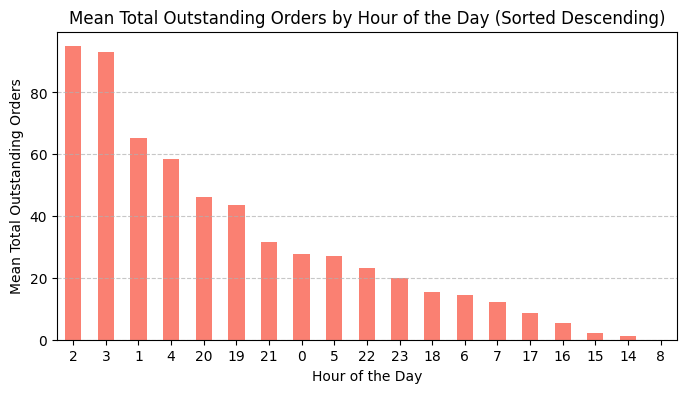

In [ ]:
hourly_orders = data.groupby('hour')['total_outstanding_orders'].mean()

# Sorting the hours by mean in descending order
hourly_orders_sorted = hourly_orders.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,4))
hourly_orders_sorted.plot(kind='bar',color='salmon')
plt.title('Mean Total Outstanding Orders by Hour of the Day (Sorted Descending)')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Total Outstanding Orders')
plt.xticks(rotation=0)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()

data.drop(columns=['hour'], inplace=True)

### Handling Missing Values

To address the missing values in the dataset,  performed the following step:

- **Dropping Rows with Null Values**: The `actual_delivery_time` column, which contains the delivery timestamps, had only 7 null values. Since these null values are minimal, decided to drop the rows containing these missing values to maintain the integrity of the dataset for analysis and model training.

In [ ]:
data.dropna(subset=['actual_delivery_time'], inplace=True)

### Feature Engineering: Extracting Date and Time Components

 Extracted additional features from the `created_at` timestamp to enhance our dataset for modeling:

- **Year Extraction**: Added a new column `created_at_year` to capture the year when the order was placed.
- **Month Extraction**: Added a new column `created_at_month` to capture the month when the order was placed.
- **Day Extraction**: Added a new column `created_at_day` to capture the day of the month when the order was placed.
- **Time in Hours**: Added a new column `created_at_time_in_hours` which represents the time of day in hours, calculated as the sum of hours, minutes converted to hours, and seconds converted to hours.

These features will help in capturing temporal patterns and seasonality in the data.



In [ ]:
data['created_at_year'] = data['created_at'].dt.year

data['created_at_month'] = data['created_at'].dt.month

data['created_at_day'] = data['created_at'].dt.day

data['created_at_time_in_hours'] = data['created_at'].dt.hour + data['created_at'].dt.minute / 60 + data['created_at'].dt.second/ 3600


### Creating a feature  Delivery Time Taken in hours.

The feature `delivery_time_taken_hours` is calculated to measure the duration of each delivery. This is done by subtracting the `created_at` timestamp from the `actual_delivery_time` and converting the result from seconds to hours. This feature helps in quantifying the delivery duration, which is essential for training regression models to predict delivery times accurately.


In [ ]:
data['delivery_time_taken_hours'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds() / 3600

In [ ]:
data.drop(columns=['actual_delivery_time','created_at'], inplace=True)

### Data-Test Split

The following code splits a dataset into data and testing sets:



In [ ]:
data , final_Test_Data = train_test_split(data,test_size=0.2,random_state=42)

### Encoding Categorical Feature: Store ID

To handle the categorical `store_id` feature, mean encoding is used. Each unique `store_id` is replaced with the average `delivery_time_taken_hours` for that store. This method provides a numerical representation of the store's impact on delivery time. After encoding, the original `store_id` column is dropped, and a new column `store_id_encoded` is added to the dataset.


In [ ]:
data['store_id'].nunique()

6595

In [ ]:
mean_encoded = data.groupby('store_id')['delivery_time_taken_hours'].mean()
data['store_id_encoded'] = data['store_id'].map(mean_encoded)
data.drop(columns=['store_id'], inplace=True)

In [ ]:
data['store_primary_category'].unique()

array([nan, 'american', 'mediterranean', 'indian', 'southern', 'mexican',
       'salad', 'thai', 'italian', 'other', 'vietnamese', 'dessert',
       'japanese', 'barbecue', 'pizza', 'burger', 'chinese', 'greek',
       'sandwich', 'breakfast', 'asian', 'sushi', 'smoothie', 'fast',
       'cafe', 'seafood', 'latin-american', 'hawaiian', 'dim-sum',
       'brazilian', 'vegetarian', 'ethiopian', 'bubble-tea', 'korean',
       'german', 'catering', 'french', 'steak', 'filipino', 'caribbean',
       'alcohol', 'middle-eastern', 'peruvian', 'malaysian', 'pasta',
       'tapas', 'moroccan', 'persian', 'cajun', 'burmese', 'turkish',
       'argentine', 'gastropub', 'singaporean', 'afghan', 'soup',
       'british', 'pakistani', 'nepalese', 'european', 'vegan',
       'convenience-store', 'comfort-food', 'gluten-free', 'african',
       'kosher', 'russian', 'spanish', 'cheese', 'chocolate', 'irish',
       'lebanese', 'indonesian', 'belgian'], dtype=object)

### Analyzing Store Primary Categories

The bar plot visualizes the top 10 most frequent store primary categories in the dataset. This analysis highlights the distribution of different store types. The top three most common categories are **American**, **Pizza**, and **Mexican**, indicating their prevalence among the stores. This insight can be useful for understanding the types of stores involved in deliveries and their impact on delivery times.



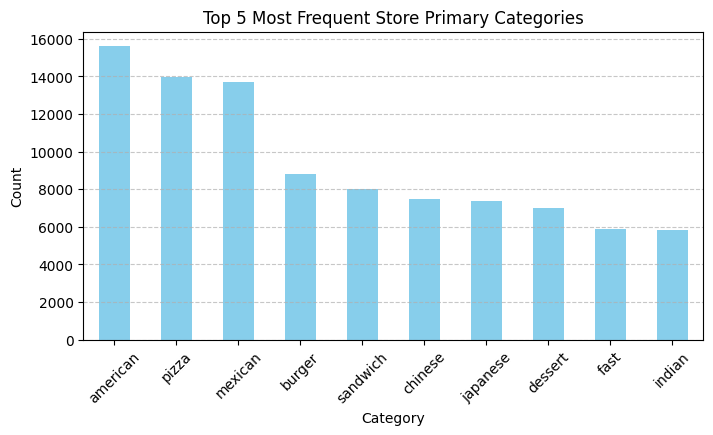

In [ ]:
category_counts = data['store_primary_category'].value_counts()

# top 5 most common categories
top_10_categories = category_counts.head(10)

# Ploting the top 5 categories
plt.figure(figsize=(8,4))
top_10_categories.plot(kind='bar',color='skyblue')
plt.title('Top 5 Most Frequent Store Primary Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()

### Analyzing Store Primary Categories by Mean Subtotal

This analysis evaluates the average subtotal for different store primary categories to identify which categories have the highest average order values. The bar plot displays the top 10 store categories with the highest mean subtotal. The top three categories are **Cheese**, **Moroccan**, and **Argentinian**, suggesting these categories generally involve higher-priced items or premium offerings.


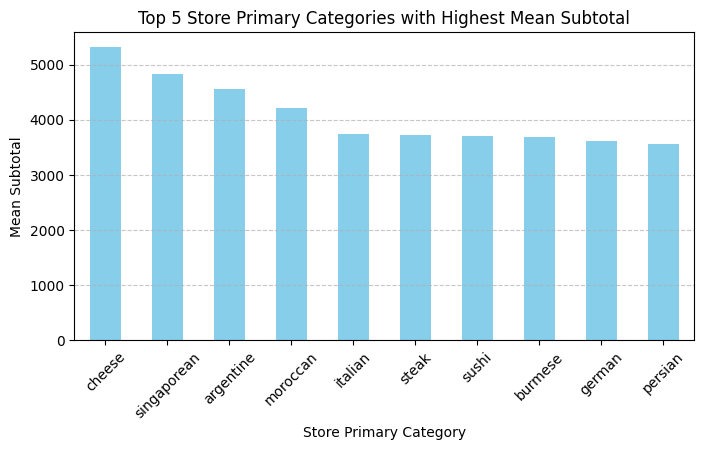

In [ ]:
category_mean_subtotal = data.groupby('store_primary_category')['subtotal'].mean()

#top 5 categories with the highest mean 'subtotal'
top_10_categories = category_mean_subtotal.nlargest(10)

# Ploting the top 5 categories
plt.figure(figsize=(8,4))
top_10_categories.plot(kind='bar',color='skyblue')
plt.title('Top 5 Store Primary Categories with Highest Mean Subtotal')
plt.xlabel('Store Primary Category')
plt.ylabel('Mean Subtotal')
plt.xticks(rotation=45)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()

### Univariate Analysis for Numerical Features

Univariate analysis of numerical features involves examining the distribution and spread of each feature in the dataset. For each numerical feature, a histogram and a boxplot are used:

- **Histogram**: Provides a visual representation of the frequency distribution of the feature's values, showing its overall distribution and shape.
- **Boxplot**: Displays summary statistics such as the median, quartiles, and potential outliers, giving insights into the feature's variability and skewness.

This analysis helps in understanding the characteristics of numerical features and identifying any anomalies or patterns.



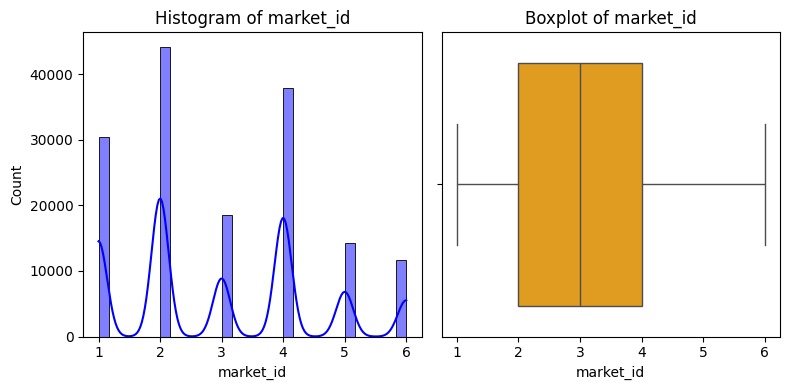

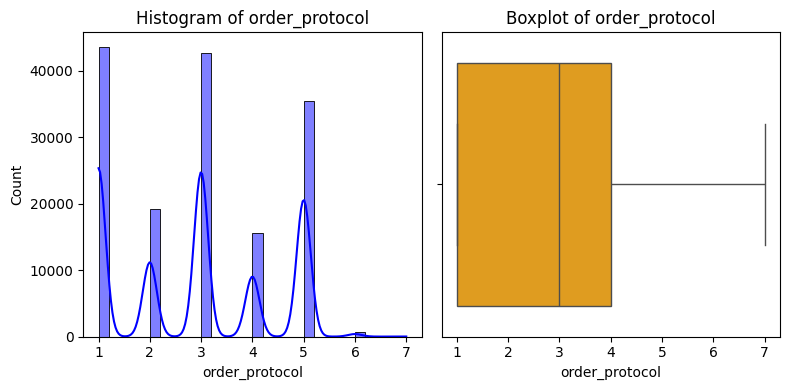

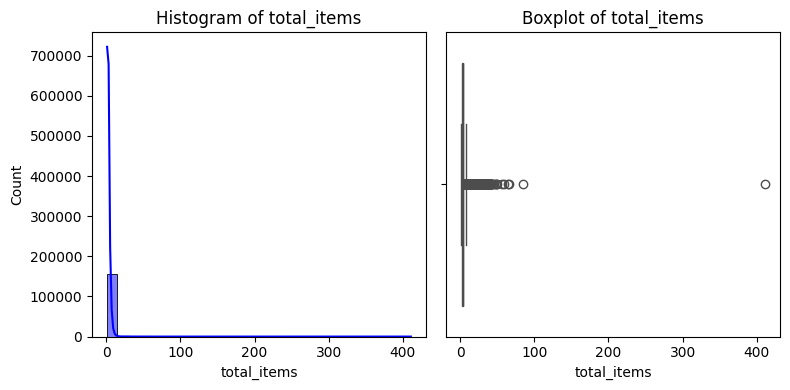

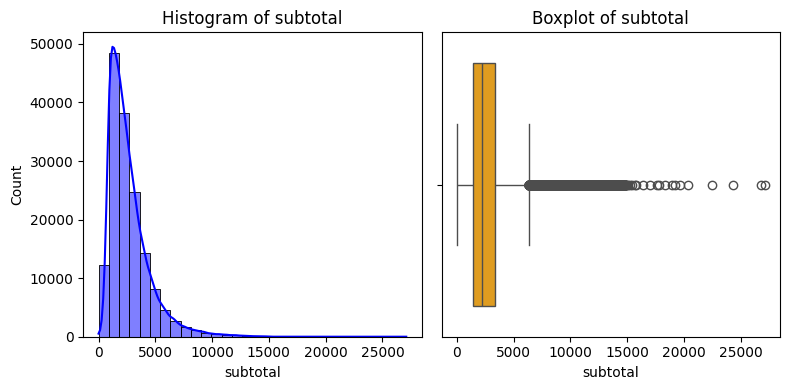

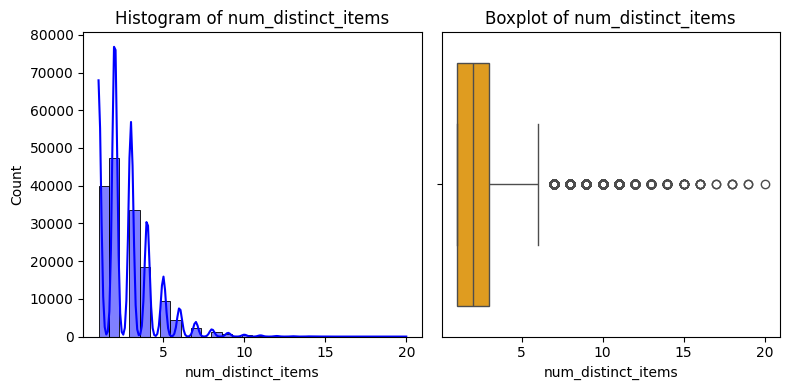

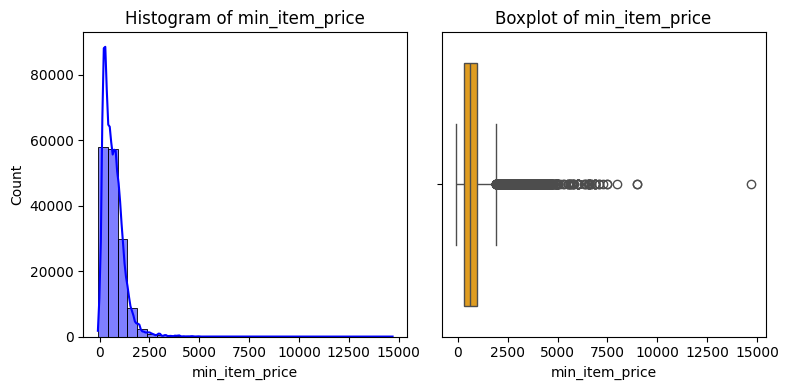

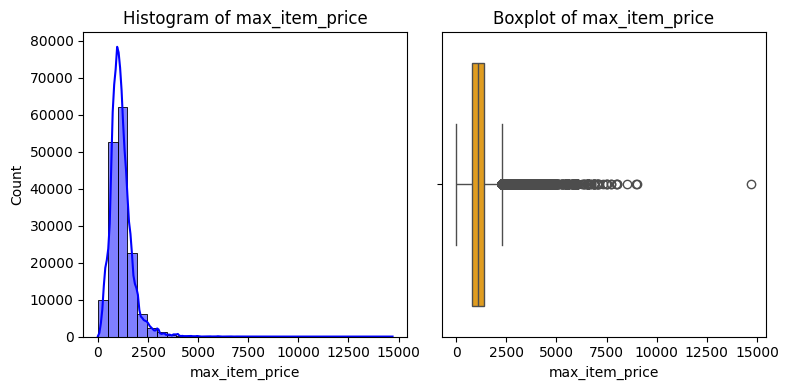

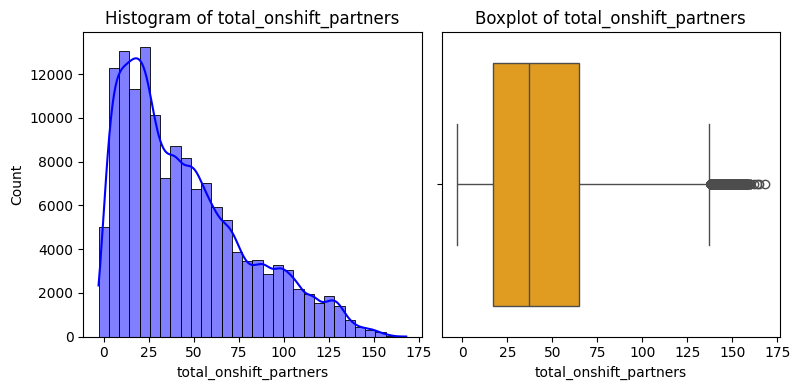

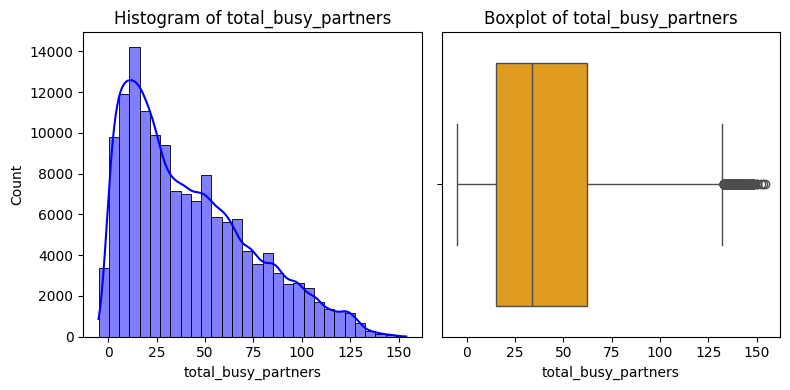

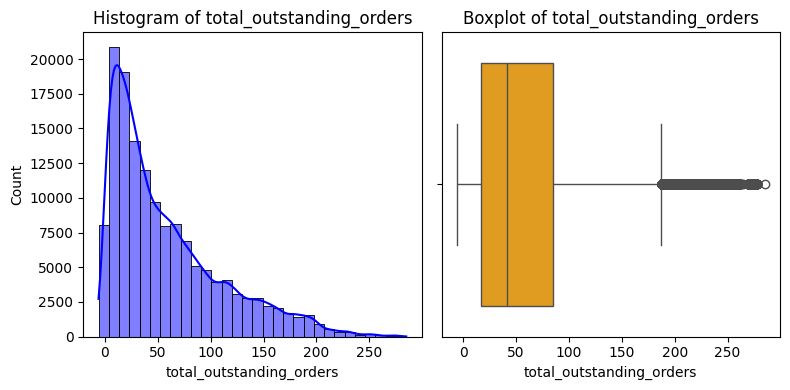

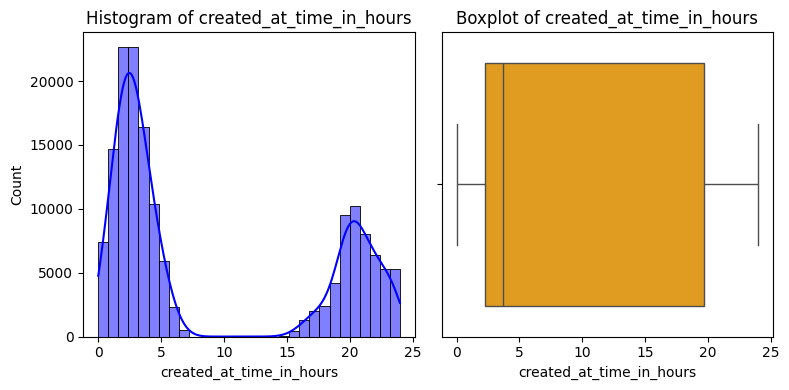

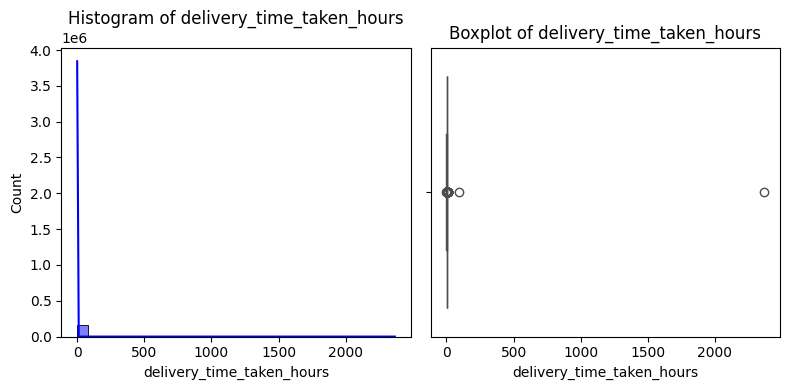

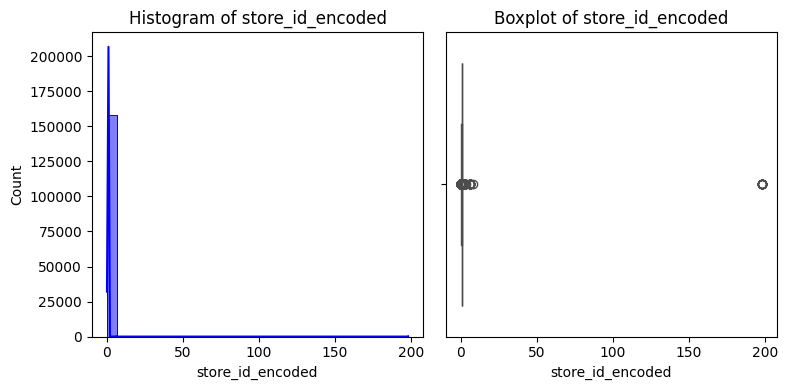

In [ ]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

# Univariate Analysis for Numerical Features
for feature in numerical_features:
    plt.figure(figsize=(8,4))

    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(data[feature],kde=True,bins=30,color='blue')
    plt.title(f'Histogram of {feature}')

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=data[feature],color='orange')
    plt.title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()

### Target Encoding for Store Primary Category

Target encoding has been applied to the `store_primary_category` feature to convert categorical values into numerical format. This encoding is based on the mean delivery time for each store category.

- **Process**: The dataset is divided into training and validation sets using 5-fold cross-validation. For each fold, the mean delivery time for each store category is calculated from the training set and used to encode the validation set.
- **Replacement**: The original `store_primary_category` column is replaced with the encoded values.

This technique captures category-specific trends in delivery times, potentially enhancing model performance by incorporating these insights.


In [ ]:
data['store_primary_category'].unique().shape

(74,)

In [ ]:
mean_encoded_col = data.groupby('store_primary_category')['delivery_time_taken_hours'].mean()


data['store_primary_category_encoded'] = data['store_primary_category'].map(mean_encoded_col)

data.drop(columns=['store_primary_category'], inplace=True)

In [ ]:
data['store_primary_category_encoded'].unique().shape

(74,)

### Handling Missing Values with KNN Imputer

To address missing values in the dataset, the KNNImputer is used. This technique imputes missing values based on the values of the nearest neighbors:

- **Method**: The `KNNImputer` is configured with 5 neighbors to fill in missing values by averaging the values of the nearest neighbors.
- **Transformation**: The imputer is applied to the dataset, and the result is converted back into a DataFrame with the original column names.

This approach ensures that missing values are filled in a way that leverages the similarity between data points, preserving the dataset's overall structure and relationships.



In [ ]:
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)

### Correlation Matrix Heatmap

The heatmap displays the correlation matrix of the dataset after imputation. It shows the relationships between numerical features.

This analysis helps in understanding how features are interrelated, which can be useful for feature selection and model refinement.


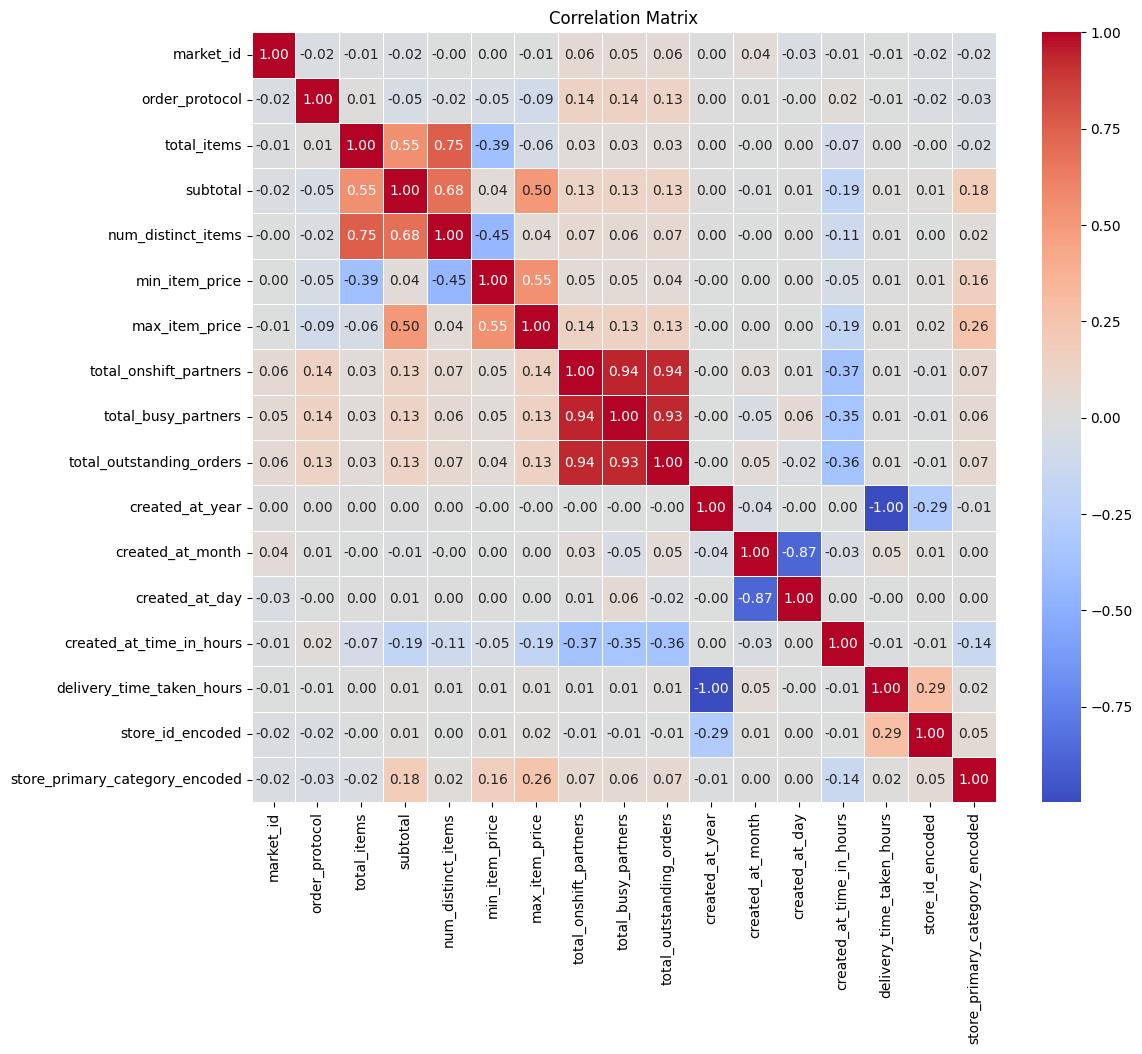

In [ ]:
correlation_matrix = data_imputed.corr()

# Ploting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
data_imputed.columns

Index(['market_id', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'created_at_year', 'created_at_month',
       'created_at_day', 'created_at_time_in_hours',
       'delivery_time_taken_hours', 'store_id_encoded',
       'store_primary_category_encoded'],
      dtype='object')

### Correlation Matrix Insights and Imputation Strategy

**Observations:**

- **High Correlations:**
  - `total_items` and `num_distinct_items` (0.76)
  - `subtotal` with `total_items` (0.56) and `num_distinct_items` (0.68)
  - `total_onshift_partners` with `total_busy_partners` (0.94) and `total_outstanding_orders` (0.93)

- **Low/Negative Correlations:**
  - `created_at_year` with `created_at_month` (-0.04) and `created_at_day` (-0.03)
  - `delivery_time_taken_hours` and `created_at_year` (-0.24)




### Outlier Detection and Removal

In this process, outliers are identified and removed using two common methods:

1. **Z-Score Method**:
   - Z-Scores for each feature are calculated to determine how far away each data point is from the mean. Outliers are those with a Z-Score absolute value greater than 3.5.
   - Indices of these outliers are noted for further processing.

2. **IQR (Interquartile Range) Method**:
   - The 25th percentile (Q1) and 75th percentile (Q3) are computed for each feature to establish the IQR.
   - Outliers are identified if they fall outside the range of Q1 - 1.5*IQR and Q3 + 1.5*IQR.
   - Indices of these outliers are recorded.

3. **Finding Common Outliers**:
   - Outliers identified by both methods are found by intersecting the indices from each method.
   - The size of these common outliers is compared with the original dataset size.

4. **Data Cleaning**:
   - Common outliers are removed from the dataset.
   - The size of the cleaned dataset is checked to ensure that the outliers have been effectively removed.

This approach ensures that outliers are systematically identified and removed, improving the quality and robustness of the data for subsequent analysis or modeling.


In [ ]:
# Step 1: Z-Score Method
# Calculating Z-Scores for each column
z_scores = stats.zscore(data_imputed)
z_scores_df = pd.DataFrame(z_scores, columns=data_imputed.columns)
z_threshold = 3.5
# Identifying outliers based on Z-scores
z_outliers = (z_scores_df.abs() > z_threshold)
z_outlier_indices = z_outliers[z_outliers.any(axis=1)].index

# Step 2: IQR Method
# Calculating Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data_imputed.quantile(0.25)
Q3 = data_imputed.quantile(0.75)
IQR = Q3 - Q1
iqr_threshold = 1.5
iqr_outliers = ((data_imputed < (Q1 - iqr_threshold * IQR)) | (data_imputed > (Q3 + iqr_threshold * IQR)))
iqr_outlier_indices = iqr_outliers[iqr_outliers.any(axis=1)].index

# Finding common outliers
common_outlier_indices = z_outlier_indices.intersection(iqr_outlier_indices)
# Printing the size of common outliers and original data
print("Common outliers size identified by both methods and original data size :")
print(common_outlier_indices.shape, data_imputed.shape)
# Dropping the common outliers from the DataFrame
df_cleaned = data_imputed.drop(index=common_outlier_indices, errors='ignore')

df_cleaned.reset_index(drop=True, inplace=True)
# Verifying the size after dropping outliers
print("Data size after dropping outliers: ")
print(df_cleaned.shape)

Common outliers size identified by both methods and original data size :
(11554,) (157936, 17)
Data size after dropping outliers: 
(146382, 17)


### Visualization of Numeric Columns

1. **Boxplot for Numeric Columns**:
   - The boxplot displays the distribution of each numeric column, highlighting the median, quartiles, and potential outliers. This helps in understanding the spread and identifying any anomalies or extreme values.

2. **Histogram for Numeric Columns**:
   - Histograms are plotted for each numeric column to show the frequency distribution of the values. This visualization helps in assessing the skewness and spread of the data for each feature.

3. **Pair Plot for Numeric Columns**:
   - The pair plot shows scatterplots for all pairs of numeric columns, along with the distribution of each individual column on the diagonal. This visualization is useful for examining relationships and correlations between pairs of features.


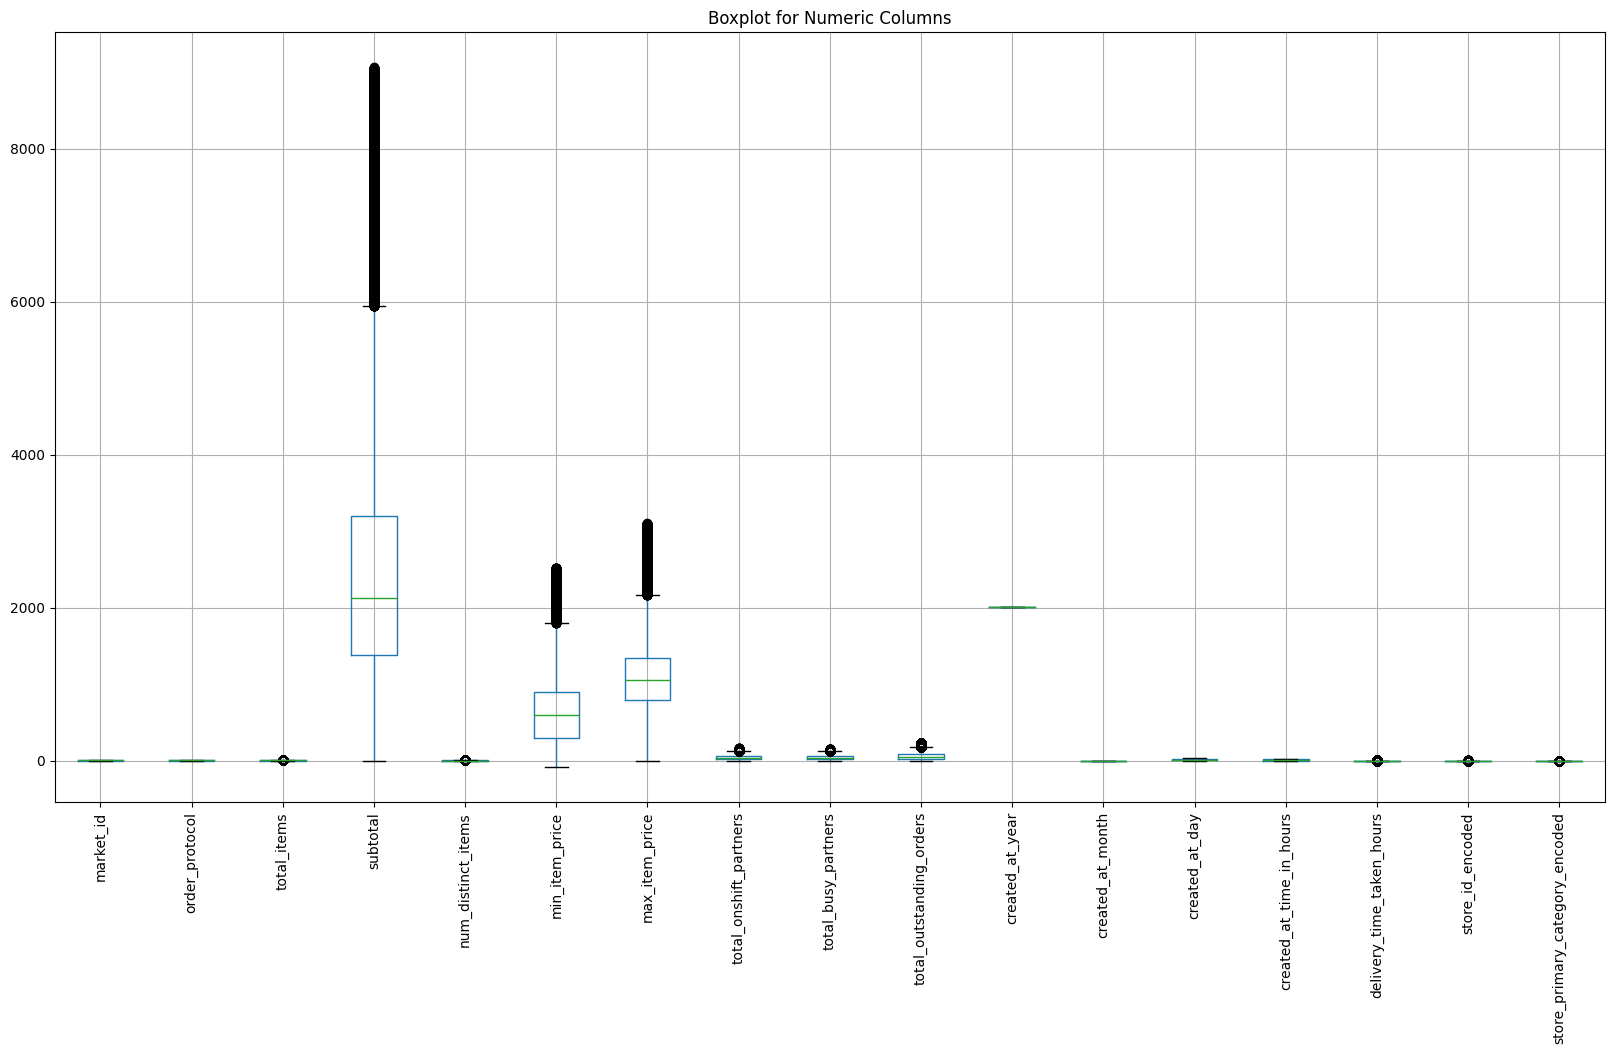

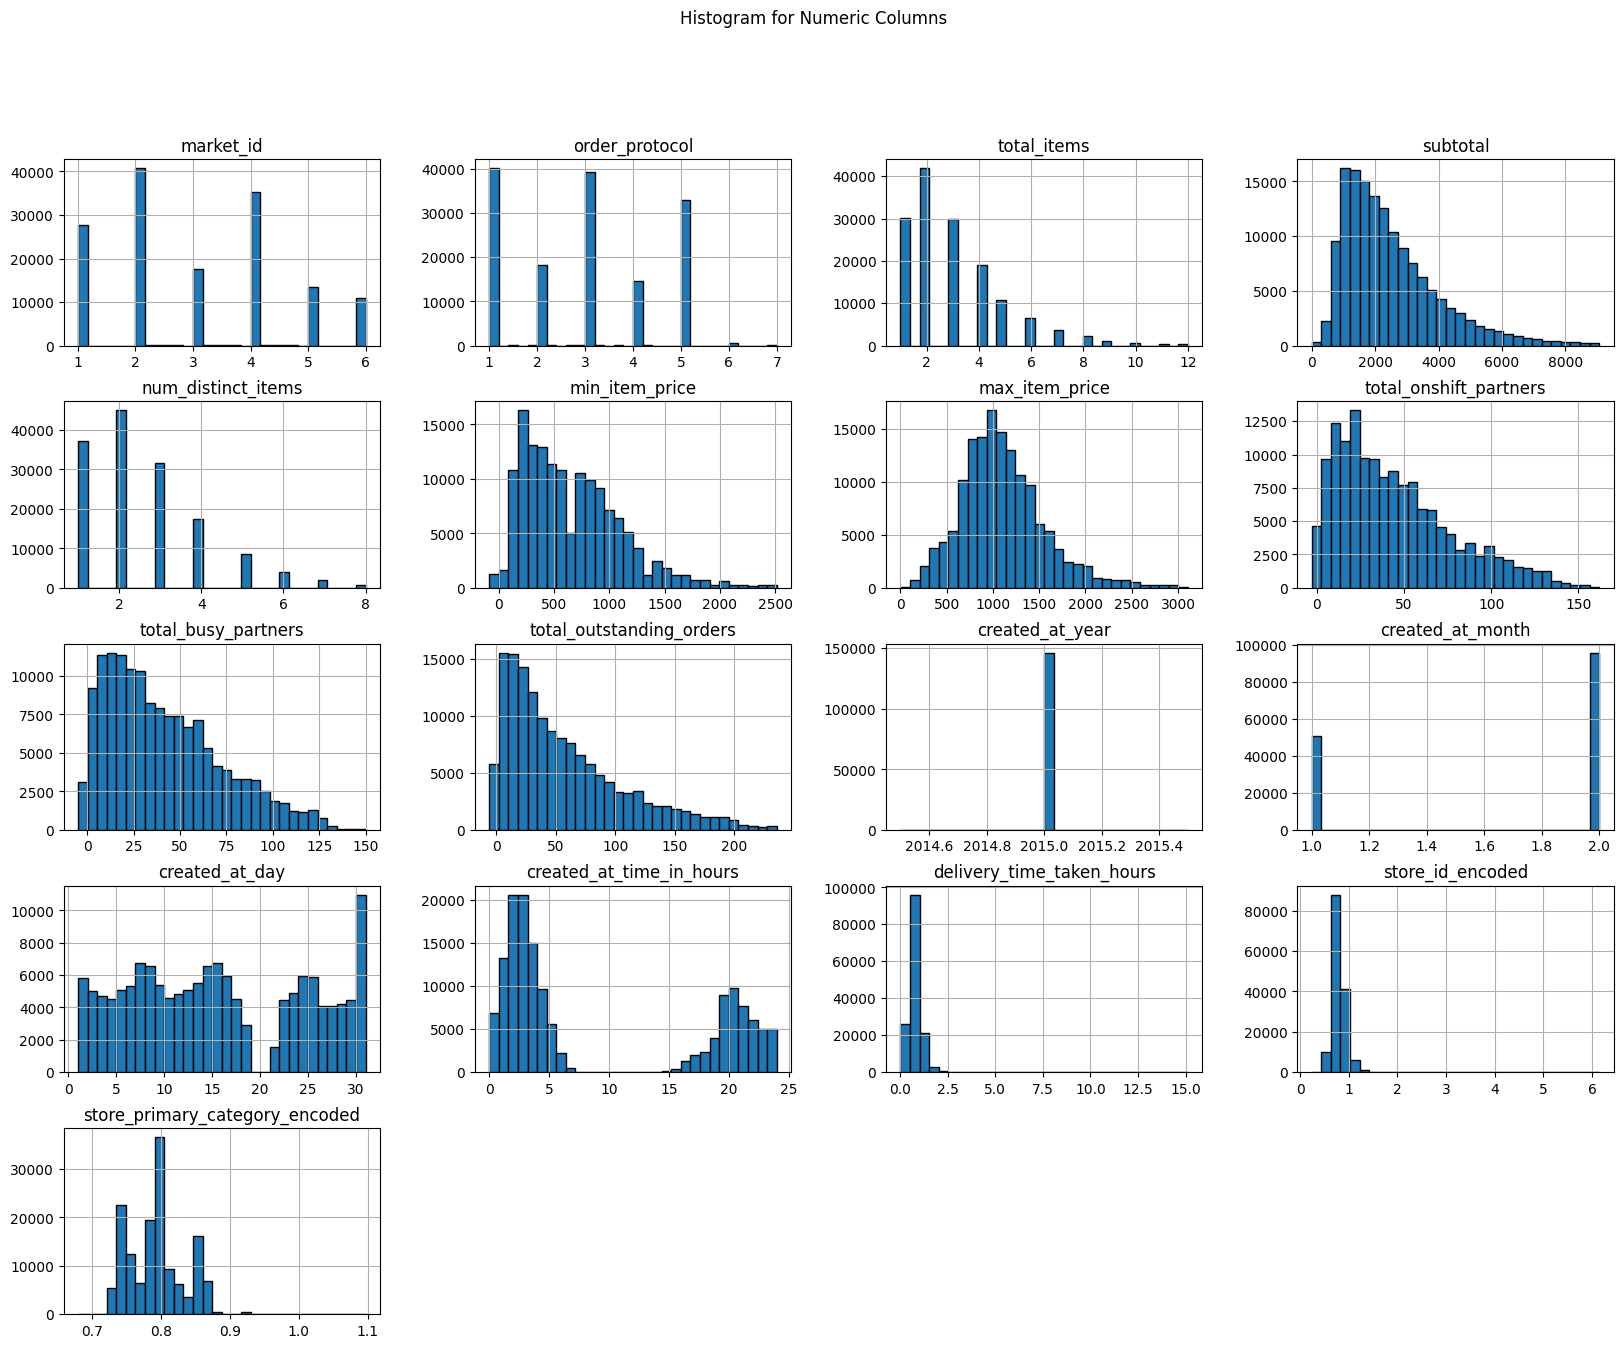

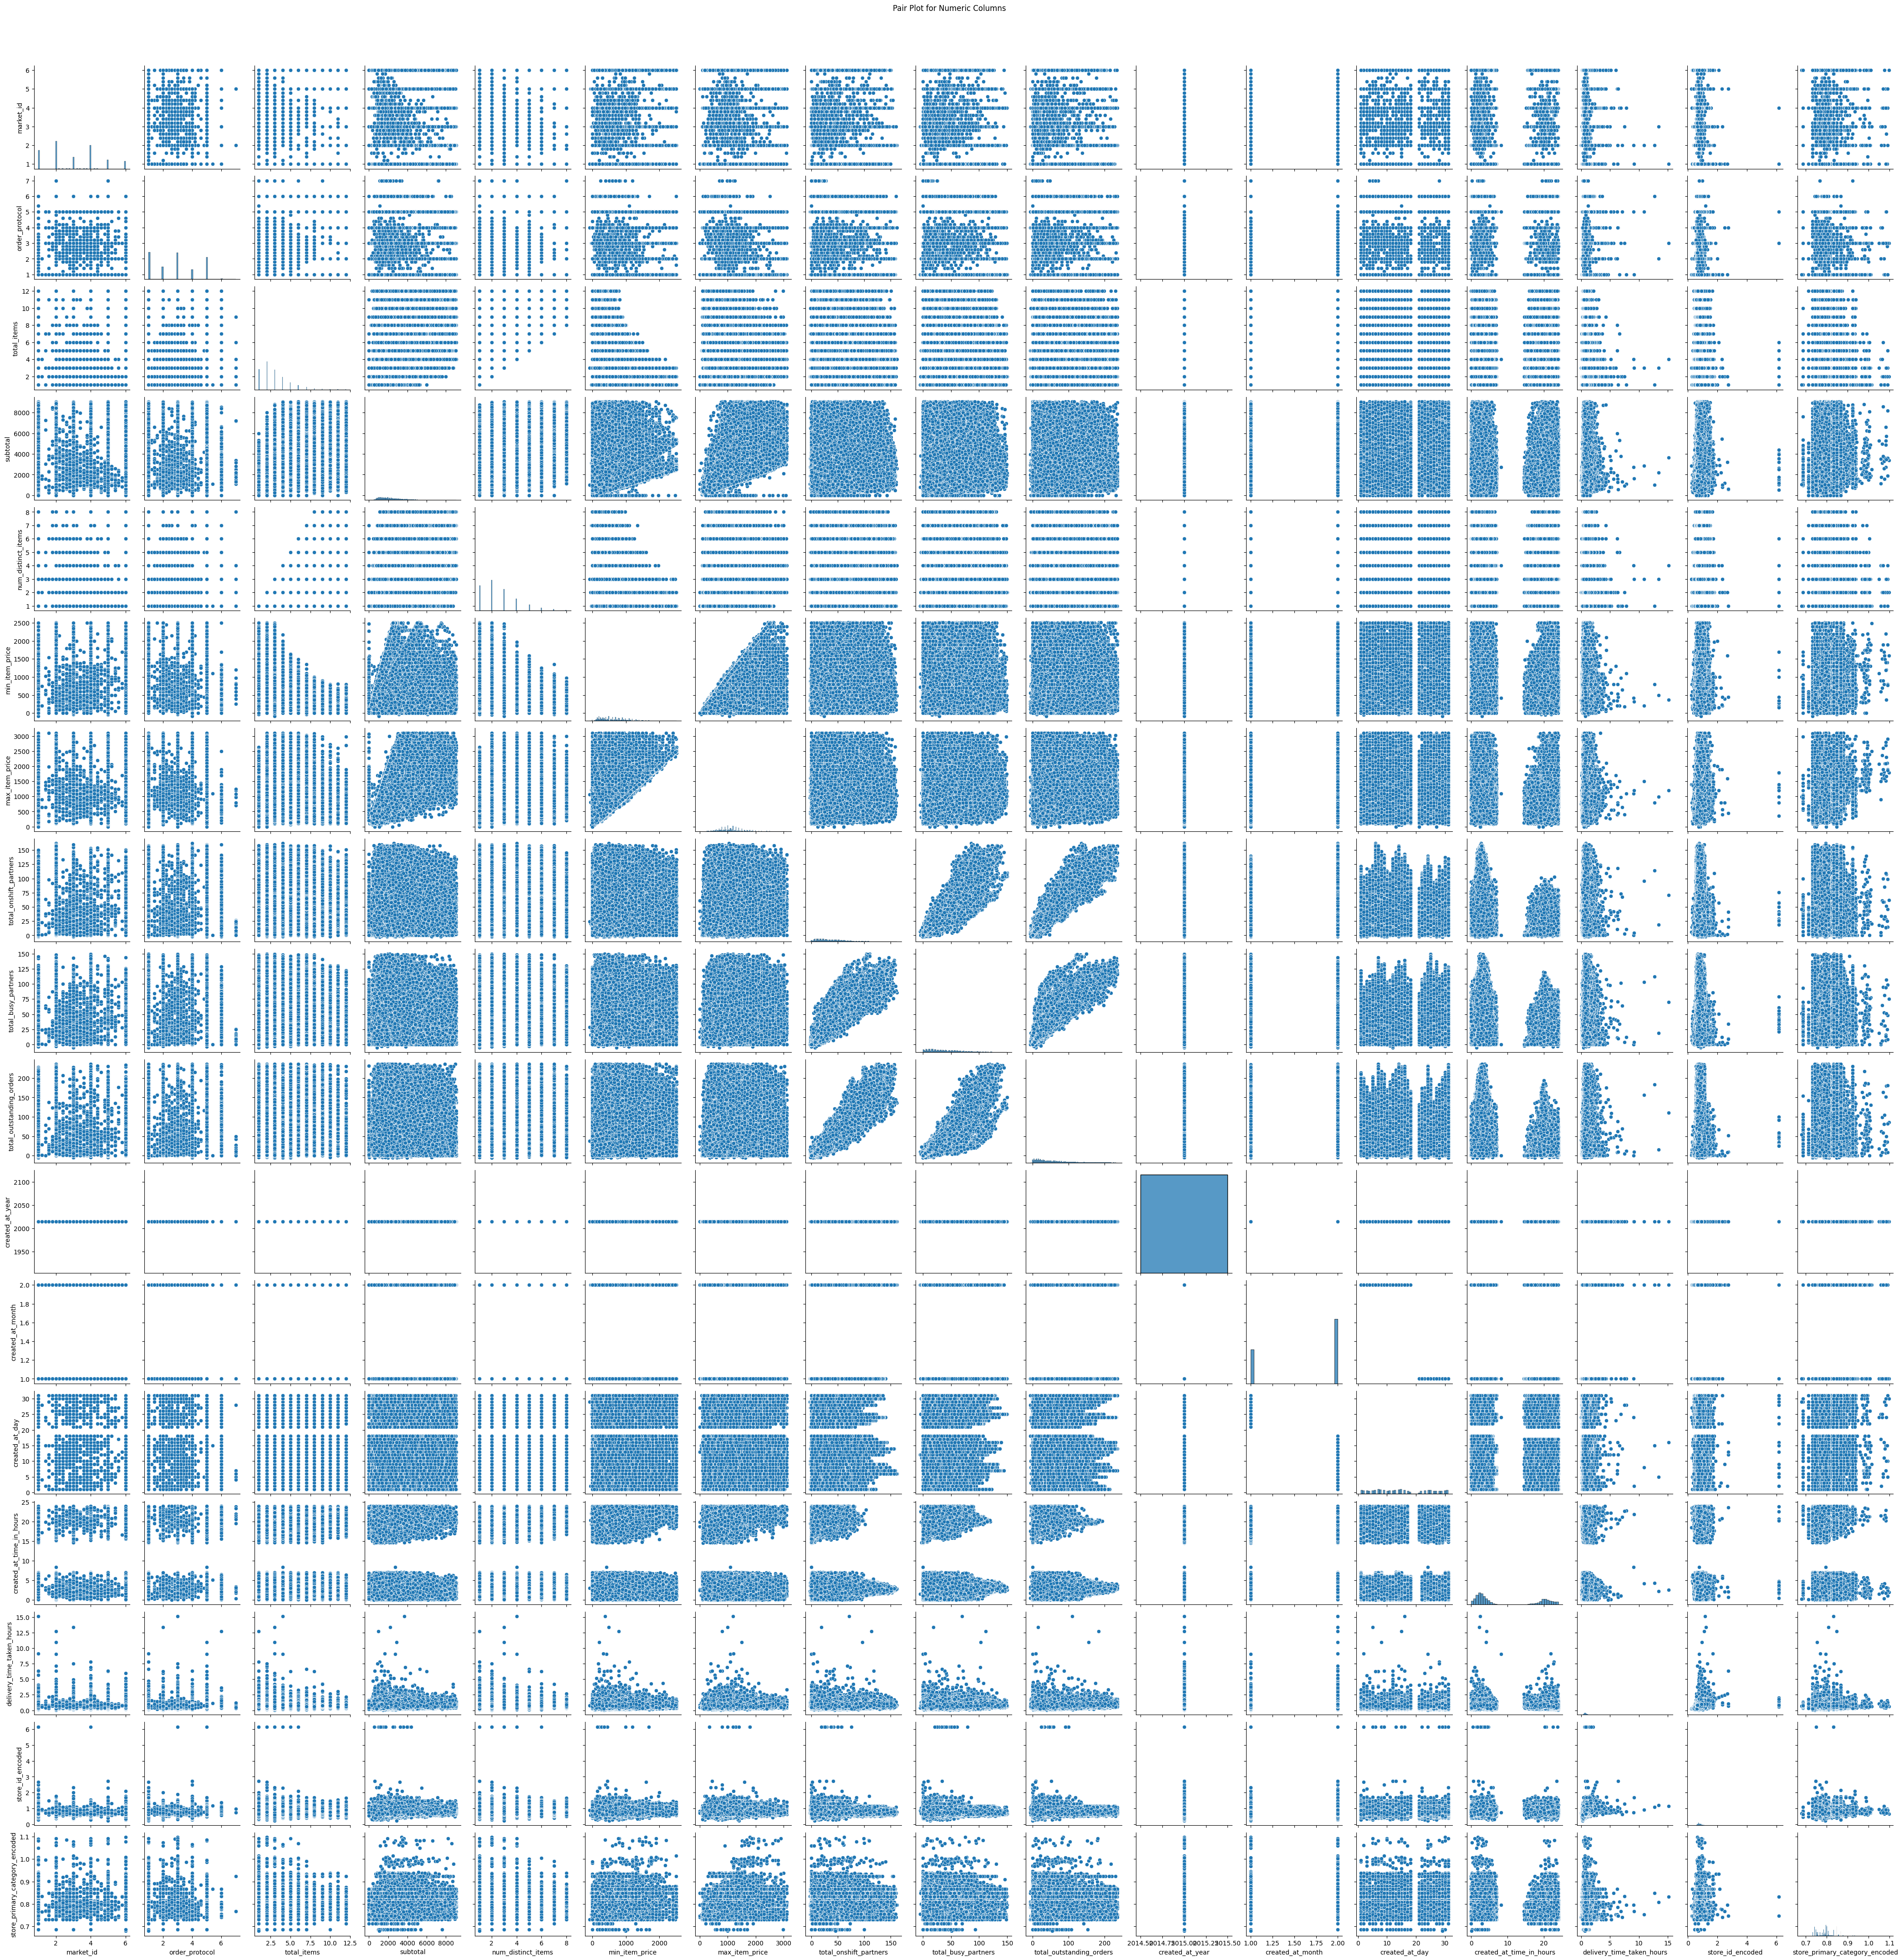

In [ ]:
#only numeric columns
numeric_data =df_cleaned.select_dtypes(include=[np.number])

# 1. Boxplot for each numeric column
plt.figure(figsize=(20,10))
numeric_data.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot for Numeric Columns')
plt.show()

# 2. Histogram for each numeric column
numeric_data.hist(figsize=(20,15),bins=30,edgecolor='black')
plt.suptitle('Histogram for Numeric Columns')
plt.show()

# 3. Pair Plot for all pairs of numeric columns
sns.pairplot(numeric_data)
plt.suptitle('Pair Plot for Numeric Columns',y=1.02)
plt.show()

In [ ]:
df=df_cleaned

### Data Splitting

The dataset is divided into features (`X`) and target (`y`). The target variable is `delivery_time_taken_hours`, and the remaining columns are used as features.

The data is then split into training and testing sets with an 80-20 split. This means that 80% of the data is used for training the model, while 20% is reserved for testing and evaluating its performance.

In [ ]:
X = df.drop('delivery_time_taken_hours',axis=1)
y = df['delivery_time_taken_hours']

# Spliting the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((117105, 16), (29277, 16), (117105,), (29277,))

### Data Scaling

The `StandardScaler` is used to standardize the features by removing the mean and scaling to unit variance.

- The scaler is fitted on the training data (`X_train`) and then used to transform both the training and testing data.


In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Neural Network Defining

A neural network model is defined with the following architecture:

- **Input Layer**: The input layer has 64 neurons and uses the ReLU  activation function. It takes in features from the training data.
- **Hidden Layers**:
  - The first hidden layer consists of 32 neurons with ReLU activation.
  - The second hidden layer has 16 neurons with ReLU activation.
- **Output Layer**: The output layer has a single neuron with a linear activation function, suitable for regression tasks where the output is a continuous value.

The model is compiled using the Adam optimizer with a learning rate of 0.001 and the mean squared error loss function.


In [ ]:
# Defining neural network
model = Sequential()

# Input layer
model.add(Dense(64,input_dim=X_train.shape[1],activation='relu'))

# Hidden layers
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))

# Output layer
model.add(Dense(1,activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Training

The neural network model is trained using the training dataset (`X_train`, `y_train`). The training process involves:

- **Epochs**: The model is trained for 50 epochs, meaning the entire dataset will be processed 50 times.
- **Batch Size**: The model is updated after processing each batch of 32 samples.
- **Validation Data**: The model's performance is evaluated on the test dataset (`X_test`, `y_test`) after each epoch to monitor validation loss and detect overfitting.

The training process returns a `history` object that contains information about the training and validation loss for each epoch, which can be used to analyze the model's performance over time.


In [ ]:
# Training the model
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=50,batch_size=32)

Epoch 1/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1077 - val_loss: 0.0730
Epoch 2/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0764 - val_loss: 0.0703
Epoch 3/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0738 - val_loss: 0.0729
Epoch 4/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0729 - val_loss: 0.0688
Epoch 5/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0697 - val_loss: 0.0694
Epoch 6/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0746 - val_loss: 0.0701
Epoch 7/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0733 - val_loss: 0.0680
Epoch 8/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0705 - val_loss: 0.0688
Epoch 9/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0750 - val_loss: 0.0682
Epoch 10/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0677 - val_loss: 0.0679
Epoch 11/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0704 - val_loss: 0.0677
Epoch 12/50
3660/3660 ━━

### Training and Validation Loss

The plot displays the training and validation loss over epochs:

By examining this plot, we can evaluate the model's performance and detect issues such as overfitting if the training loss continues to decrease while the validation loss starts to increase.


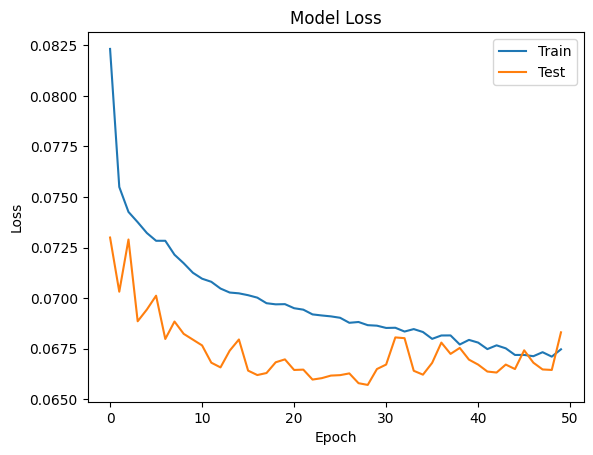

In [ ]:
# Ploting training & validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### Model Evaluation Metrics

The evaluation metrics for the neural network model on the test set are as follows:

- **Mean Squared Error (MSE)**: 0.0707
- **Root Mean Squared Error (RMSE)**: 0.2659
- **Mean Absolute Error (MAE)**: 0.1801

These metrics give a comprehensive view of the model's accuracy and error in predictions.


In [ ]:
# Predictions on  test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

915/915 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 0.06830146050855969
RMSE: 0.2613454811328478
MAE: 0.179617116020126
R²: 0.3106020381571609


# Feature Encoding and Data Transformation for Final Test Set

Encoding the Final test data using the mean store_id and store_primary_category of train data so there is no leakage in train data while encoding.



In [ ]:
final_Test_Data['store_id_encoded'] = final_Test_Data['store_id'].map(mean_encoded)
final_Test_Data.drop(columns=['store_id'], inplace=True)

final_Test_Data['store_primary_category_encoded'] = final_Test_Data['store_primary_category'].map(mean_encoded_col)
final_Test_Data.drop(columns=['store_primary_category'], inplace=True)

final_Test_Data = imputer.transform(final_Test_Data)
final_Test_Data = pd.DataFrame(final_Test_Data, columns=data.columns)

# Final Test Dataset Evaluation

In this section, we evaluate the performance of our trained model on the final test dataset. The process involves:

1. **Preparing Data**:
   - Features are separated from the target variable, `delivery_time_taken_hours`.
   - Features are scaled using the same scaler applied to the training data.

2. **Making Predictions**:
   - The model predicts delivery times using the scaled features.

3. **Calculating Metrics**:
   - **Mean Squared Error (MSE)**: Measures the average squared difference between actual and predicted values.
   - **Root Mean Squared Error (RMSE)**: The square root of MSE, showing the error in the same units as the target.
   - **Mean Absolute Error (MAE)**: The average absolute difference between actual and predicted values.
   - **R² Score**: Indicates the proportion of variance in the target variable explained by the model.

### Results:
- **MSE**: 0.3555
- **RMSE**: 0.5962
- **MAE**: 0.1928
- **R²**: 0.0529

**Summary**:
The evaluation metrics indicate that while the model provides predictions, its performance is limited. The R² score is quite low, suggesting that the model explains only a small fraction of the variance in the target variable. Further refinement of the model or additional feature engineering may be needed to improve predictive accuracy.




In [ ]:
X_final_test = final_Test_Data.drop(columns=['delivery_time_taken_hours'])
y_final_test = final_Test_Data['delivery_time_taken_hours']


X_final_test_scaled = scaler.transform(X_final_test)


y_final_test_pred = model.predict(X_final_test_scaled)

mse_final_test = mean_squared_error(y_final_test, y_final_test_pred)
rmse_final_test = np.sqrt(mse_final_test)
mae_final_test = mean_absolute_error(y_final_test, y_final_test_pred)
r2_final_test = r2_score(y_final_test, y_final_test_pred)

1234/1234 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
print(f"MSE: {mse_final_test}")
print(f"RMSE: {rmse_final_test}")
print(f"MAE: {mae_final_test}")
print(f"R²: {r2_final_test}")

MSE: 0.35549842932853093
RMSE: 0.5962368902781268
MAE: 0.19280742975181203
R²: 0.05291999886526


# Neural Network Model with Dropout and Early Stopping

In this section, we implemented a neural network model to predict delivery times. We used feature scaling to standardize our input features, which helps the model converge faster and perform better.

## Model Architecture and Training

We defined a neural network with the following architecture:
- **Input Layer**: 128 units with ReLU activation and a dropout rate of 0.5 to prevent overfitting.
- **Hidden Layers**:
  - 64 units with ReLU activation and dropout.
  - 32 units with ReLU activation.
- **Output Layer**: Single unit with a linear activation function for regression tasks.

The model was compiled using the Adam optimizer with a learning rate of 0.0005 and mean squared error as the loss function. Early stopping was employed to halt training when the validation loss stopped improving for 10 epochs.

## Training and Evaluation

The model was trained for up to 100 epochs with a batch size of 32. The training process was monitored using early stopping to avoid overfitting.

### Results
- **Mean Squared Error (MSE)**: 0.0704
- **Root Mean Squared Error (RMSE)**: 0.2653
- **Mean Absolute Error (MAE)**: 0.1872
- **R² Score**: 0.2894

### Explanation

- **MSE**: Represents the average squared difference between the actual and predicted values. A lower MSE indicates better model performance.
- **RMSE**: The square root of MSE, providing error magnitude in the same units as the target variable. A lower RMSE suggests the model's predictions are close to the actual values.
- **MAE**: Shows the average absolute error between actual and predicted values. Lower MAE indicates less error in predictions.
- **R² Score**: Measures the proportion of variance in the target variable that is predictable from the features. A value of 0.2894 indicates that the model explains approximately 29% of the variance.

The results demonstrate that the neural network model effectively predicts delivery times with reasonable accuracy, although there is still room for improvement.


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1665 - val_loss: 0.0792
Epoch 2/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0821 - val_loss: 0.0742
Epoch 3/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0818 - val_loss: 0.0733
Epoch 4/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0728 - val_loss: 0.0719
Epoch 5/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0740 - val_loss: 0.0716
Epoch 6/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0766 - val_loss: 0.0723
Epoch 7/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0728 - val_loss: 0.0732
Epoch 8/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0745 - val_loss: 0.0744
Epoch 9/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0770 - val_loss: 0.0722
Epoch 10/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0725 - val_loss: 0.0718
Epoch 11/100
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0734 - val_loss: 0.0704
Epoch 12/100
3660/3660

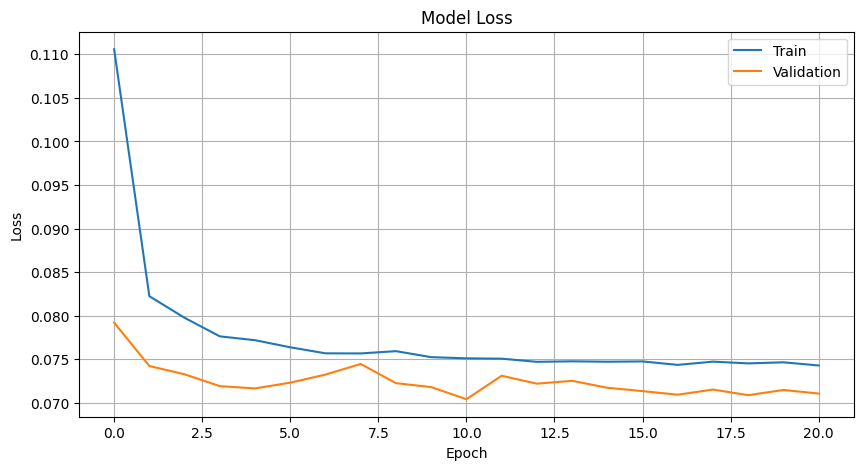

915/915 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 0.07040324908408506
RMSE: 0.26533610588098455
MAE: 0.18719428257665993
R²: 0.2893877222493748


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definingneural network
model = Sequential()

# Input layer
model.add(Dense(128,input_dim=X_train_scaled.shape[1],activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Hidden layers
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))

# Output layer
model.add(Dense(1,activation='linear'))

# Compiling the model with a different learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

# Training  model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test),
                    epochs=100,batch_size=32,callbacks=[early_stopping])

# Ploting training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculatoing MSE, RMSE, MAE, and R²
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Final Test Evaluation Results

In this section, we evaluate the performance of our trained model on the final test data. The following metrics were computed to assess how well the model generalizes to new, unseen data.

## Predictions and Evaluation Metrics

- **Predictions**: The model was used to predict the target variable (`delivery_time_taken_hours`) on the scaled final test dataset.
- **Metrics Calculated**:
  - **Mean Squared Error (MSE)**: 0.4398
  - **Root Mean Squared Error (RMSE)**: 0.6631
  - **Mean Absolute Error (MAE)**: 0.1995
  - **R² Score**: -0.1716

### Explanation of Results

- **MSE (Mean Squared Error)**: Indicates the average squared difference between actual and predicted values. A higher MSE suggests that the predictions deviate more from the actual values.
- **RMSE (Root Mean Squared Error)**: The square root of MSE, providing error magnitude in the same units as the target variable. A higher RMSE indicates poorer prediction accuracy.
- **MAE (Mean Absolute Error)**: Shows the average absolute error between actual and predicted values. This value indicates how far off the predictions are from the actual values, on average.
- **R² Score**: Measures the proportion of variance in the target variable explained by the model. A negative R² value suggests that the model performs worse than a simple mean-based prediction.

### Summary

The evaluation metrics indicate that the model's performance on the final test set is suboptimal, with high errors and a negative R² score. This suggests that the model does not generalize well to new data and improvements may be needed in model architecture, feature engineering, or hyperparameter tuning.


In [ ]:
y_final_test_pred = model.predict(X_final_test_scaled)

mse_final_test = mean_squared_error(y_final_test, y_final_test_pred)
rmse_final_test = np.sqrt(mse_final_test)
mae_final_test = mean_absolute_error(y_final_test, y_final_test_pred)
r2_final_test = r2_score(y_final_test, y_final_test_pred)

1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
print(f"MSE: {mse_final_test}")
print(f"RMSE: {rmse_final_test}")
print(f"MAE: {mae_final_test}")
print(f"R²: {r2_final_test}")

MSE: 0.43976479050018524
RMSE: 0.6631476385392511
MAE: 0.19949436424335157
R²: -0.17157321643476542


# Hyperparameter Tuning and Model Evaluation

## Model Creation and Hyperparameter Tuning

1. **Model Creation**:
   - A neural network model is created with customizable parameters including learning rate, number of layers, number of nodes, dropout rate, and regularization strengths.
   - The model consists of an input layer, a series of hidden layers with dropout for regularization, and an output layer.

2. **Hyperparameters Defined**:
   - The hyperparameters to be tuned include:
     - `learning_rate`: 0.001
     - `num_layers`: [1, 2, 3]
     - `num_nodes`: [32, 64]
     - `dropout_rate`: [0.2, 0.5]
     - `l1`: 0.01
     - `l2`: 0.01
     - `batch_size`: 32
     - `epochs`: 15

3. **Training and Evaluation**:
   - Data is split into training and validation sets.
   - For each combination of hyperparameters, the model is trained and evaluated on the validation set.
   - The model with the lowest mean squared error (MSE) is selected as the best model.

## Final Model Evaluation

- **Final Model Performance**:
  - **Mean Squared Error (MSE)**: 0.0791
  - **Root Mean Squared Error (RMSE)**: 0.2812
  - **Mean Absolute Error (MAE)**: 0.1913
  - **R² Score**: 0.2016

### Results Summary

- The final model shows a moderate performance with an R² score of approximately 0.20, indicating that around 20% of the variance in the target variable is explained by the model.
- The MSE and RMSE values are relatively low, suggesting that the predictions are close to the actual values.
- The MAE indicates that on average, the model’s predictions are about 0.19 units away from the actual values.

These results reflect a reasonable predictive performance, but there may still be room for improvement, potentially through further tuning or feature engineering.


In [ ]:
# Function to create the model
def create_model(learning_rate=0.001, num_layers=2, num_nodes=32, dropout_rate=0.5, l1=0.01, l2=0.01):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))  # Input layer

    # Adding hidden layers based on num_layers and num_nodes
    for _ in range(num_layers):
        model.add(Dense(num_nodes, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compiling model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Defining hyperparameters
param_grid = {
    'learning_rate': [0.001],
    'num_layers': [1, 2, 3],
    'num_nodes': [32, 64],
    'dropout_rate': [0.2, 0.5],
    'l1': [0.01],
    'l2': [0.01],
    'batch_size': [32],
    'epochs': [15]
}

# Spliting data
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Initializing best score and parameters
best_score = float('inf')
best_params = {}

# Iterating over hyperparameters
for params in ParameterGrid(param_grid):
    model = create_model(**{k: v for k, v in params.items() if k not in ['batch_size', 'epochs']})
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
              epochs=params['epochs'], batch_size=params['batch_size'],
              callbacks=[early_stopping], verbose=0)

    # Evaluating the model
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)

    if mse < best_score:
        best_score = mse
        best_params = params

print(f"Best MSE: {best_score} using {best_params}")

# Retraining the best model on the full training data
best_model = create_model(**{k: v for k, v in best_params.items() if k not in ['batch_size', 'epochs']})
best_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
               epochs=best_params['epochs'], batch_size=best_params['batch_size'],
               callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
               verbose=0)

# Final evaluation on the test set
y_test_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Final Model - MSE: {mse}")
print(f"Final Model - RMSE: {rmse}")
print(f"Final Model - MAE: {mae}")
print(f"Final Model - R²: {r2}")

240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best MSE: 0.08388381918500755 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 15, 'l1': 0.01, 'l2': 0.01, 'learning_rate': 0.001, 'num_layers': 1, 'num_nodes': 64}
915/915 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final Model - MSE: 0.0790965930117422
Final Model - RMSE: 0.28124116521544673
Final Model - MAE: 0.19127704304017162
Final Model - R²: 0.20164181548981763


# Summary

## Overview
The goal was to develop a predictive model to estimate delivery times for Porter, using a dataset with various features related to stores and delivery operations. The process involved data preprocessing, feature engineering, model building, hyperparameter tuning, and evaluation.

## Data Preprocessing
1. **Feature Engineering**:
   - **Encoding Categorical Variables**: Mean encoding was used to transform categorical features such as `store_id` and `store_primary_category` into numerical values based on the mean target values.
   - **Handling Missing Values**: Missing values in the dataset were imputed using appropriate techniques to ensure completeness.

2. **Feature Scaling**:
   - **Standardization**: Features were scaled using `StandardScaler` to ensure that all features contributed equally to the model training.

## Model Building and Hyperparameter Tuning
1. **Neural Network Model**:
   - A neural network model was defined with an input layer, several hidden layers with dropout for regularization, and an output layer.
   - Dropout layers were added to prevent overfitting, and the model was compiled with a learning rate of 0.0005 and the `mean_squared_error` loss function.

2. **Hyperparameter Search**:
   - **Hyperparameters Tuned**:
     - Learning rate
     - Number of layers and nodes
     - Dropout rate
     - Regularization strengths (L1 and L2)
   - The model was trained with different combinations of these hyperparameters using a grid search approach to identify the best performing configuration.

## Model Evaluation
1. **Validation Performance**:
   - The best model was selected based on the lowest mean squared error (MSE) on the validation set.

2. **Final Model Performance**:
   - **MSE**: 0.0791
   - **RMSE**: 0.2812
   - **MAE**: 0.1913
   - **R² Score**: 0.2016

   These metrics indicate a moderate level of performance, with the model explaining approximately 20% of the variance in delivery times. The MSE and RMSE values are relatively low, suggesting that the predictions are reasonably close to actual values.

## Key Takeaways
- **Feature Engineering** and **Feature Scaling** were crucial steps in preparing the data for modeling.
- **Dropout and Regularization** techniques were implemented to prevent overfitting and improve generalization.
- The **hyperparameter tuning** process helped identify the optimal model configuration for the given data.
- The final model demonstrated reasonable predictive performance, but there may be opportunities for further improvements through additional feature engineering or advanced modeling techniques.

This summary provides a comprehensive view of the work completed and the results achieved in the Porter business case analysis.
